In [1]:
import joblib
import numpy as np
import joblib
import numpy as np
import networkx as nx
import yaml
import utilities as ut 
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt

import opt_tools_test as optools


[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [2]:
experiment = 'lilucas'

In [3]:
config_files = {
                    'hyperparams_diroca': 'configs/diroca_opt_config.yaml',
                    'hyperparams_gradca': 'configs/gradca_opt_config.yaml',
                    'hyperparams_baryca': 'configs/baryca_opt_config.yaml'
                }
configs = ut.load_configs(config_files)

hyperparams_diroca = configs['hyperparams_diroca']
hyperparams_gradca = configs['hyperparams_gradca']
hyperparams_baryca = configs['hyperparams_baryca']

In [4]:
all_data   = ut.load_all_data(experiment)
all_data['experiment_name'] = experiment

Dll_obs     = all_data['LLmodel']['data'][None]
Dhl_obs     = all_data['HLmodel']['data'][None]
folds_path  = f"data/{experiment}/cv_folds.pkl"
saved_folds = ut.prepare_cv_folds(Dll_obs, hyperparams_diroca['k_folds'], hyperparams_diroca['seed'], folds_path)

Data loaded for 'lilucas'.
Created and saved 2 folds to 'data/lilucas/cv_folds.pkl'


In [5]:
# --- The Main Optimization and Evaluation Loop ---
diroca_cv_results = {}

# Iterate through each cross-validation fold
for i, fold_info in enumerate(saved_folds):
    print(f"\n--- Starting Cross-Validation for Fold {i+1}/{len(saved_folds)} ---")
    
    # Create a new sub-dictionary for the current fold
    fold_key = f'fold_{i}'
    diroca_cv_results[fold_key] = {}
    
    # Determine the fold-specific radius bound
    train_n = len(fold_info['train'])
    ll_bound = round(ut.compute_radius_lb(N=train_n, eta=0.05, c=1000), 3)
    eps_delta_values = [4, 8, 1, 2, ll_bound]

    # Iterate through each radii value
    for eps_delta in eps_delta_values:
        print(f"  - Training for ε=δ = {eps_delta}")

        # Assemble parameters for this specific run
        params_for_this_run = ut.assemble_fold_parameters(fold_info, all_data, hyperparams_diroca)
        params_for_this_run['theta_hatL']['radius'] = eps_delta
        params_for_this_run['theta_hatH']['radius'] = eps_delta
        
        opt_args = params_for_this_run.copy()
        opt_args.pop('k_folds', None)
        
        # Run the optimization
        trained_params, trained_T, monitor = optools.run_erica_optimization(**opt_args)
        
        # Store the results 
        hyperparam_key = f'eps_delta_{eps_delta}'
        diroca_cv_results[fold_key][hyperparam_key] = {
            'T_matrix': trained_T,
            'optimization_params': trained_params,
            'test_indices': fold_info['test'],
            'monitor': monitor
        }

print("\n\n--- Optimization Complete ---")


--- Starting Cross-Validation for Fold 1/2 ---
  - Training for ε=δ = 4
Running optimization on device: cpu


Optimizing:   8%|▊         | 160/2000 [00:47<09:09,  3.35it/s]


Convergence reached at epoch 161
  - Training for ε=δ = 8
Running optimization on device: cpu


Optimizing:  20%|█▉        | 397/2000 [01:53<07:39,  3.49it/s]


Convergence reached at epoch 398
  - Training for ε=δ = 1
Running optimization on device: cpu


Optimizing:  52%|█████▎    | 1050/2000 [04:54<04:26,  3.56it/s]


Convergence reached at epoch 1051
  - Training for ε=δ = 2
Running optimization on device: cpu


Optimizing:  29%|██▉       | 575/2000 [02:41<06:39,  3.56it/s]


Convergence reached at epoch 576
  - Training for ε=δ = 0.14
Running optimization on device: cpu


Optimizing:  43%|████▎     | 851/2000 [04:04<05:30,  3.48it/s]


Convergence reached at epoch 852

--- Starting Cross-Validation for Fold 2/2 ---
  - Training for ε=δ = 4
Running optimization on device: cpu


Optimizing:   8%|▊         | 160/2000 [00:45<08:46,  3.49it/s]


Convergence reached at epoch 161
  - Training for ε=δ = 8
Running optimization on device: cpu


Optimizing:  20%|█▉        | 397/2000 [01:53<07:37,  3.50it/s]


Convergence reached at epoch 398
  - Training for ε=δ = 1
Running optimization on device: cpu


Optimizing:  52%|█████▎    | 1050/2000 [04:54<04:26,  3.56it/s]


Convergence reached at epoch 1051
  - Training for ε=δ = 2
Running optimization on device: cpu


Optimizing:  29%|██▉       | 575/2000 [02:39<06:35,  3.60it/s]


Convergence reached at epoch 576
  - Training for ε=δ = 0.14
Running optimization on device: cpu


Optimizing:  43%|████▎     | 851/2000 [03:56<05:19,  3.59it/s]

Convergence reached at epoch 852


--- Optimization Complete ---


In [6]:
print('diroca done!')

diroca done!


In [7]:
fold_to_inspect = 'fold_0'
hyperparam_to_inspect = 'eps_delta_8' # Use a key that exists in your results

result = diroca_cv_results[fold_to_inspect][hyperparam_to_inspect]
monitor = result['monitor']

fold_info = saved_folds[int(fold_to_inspect.split('_')[1])]

initial_params = ut.assemble_fold_parameters(fold_info, all_data, hyperparams_diroca)

initial_params_L = initial_params['theta_hatL']
initial_params_H = initial_params['theta_hatH']

final_params = result['optimization_params']



--- Distribution Summary: Low-Level Model ---

Mean (μ):
  - Initial: [0.  0.  0.1 0.1 0.3 0.2]
  - Final  : [ 0.148 -0.268 -0.116 -0.252 -0.336 -0.144]

Variances (diag(Σ)):
  - Initial: [0.5 2.  1.  1.5 0.8 1.2]
  - Final  : [9.485 7.134 4.942 3.23  0.039 0.982]

Final Correlation Matrix:
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
----------------------------------------


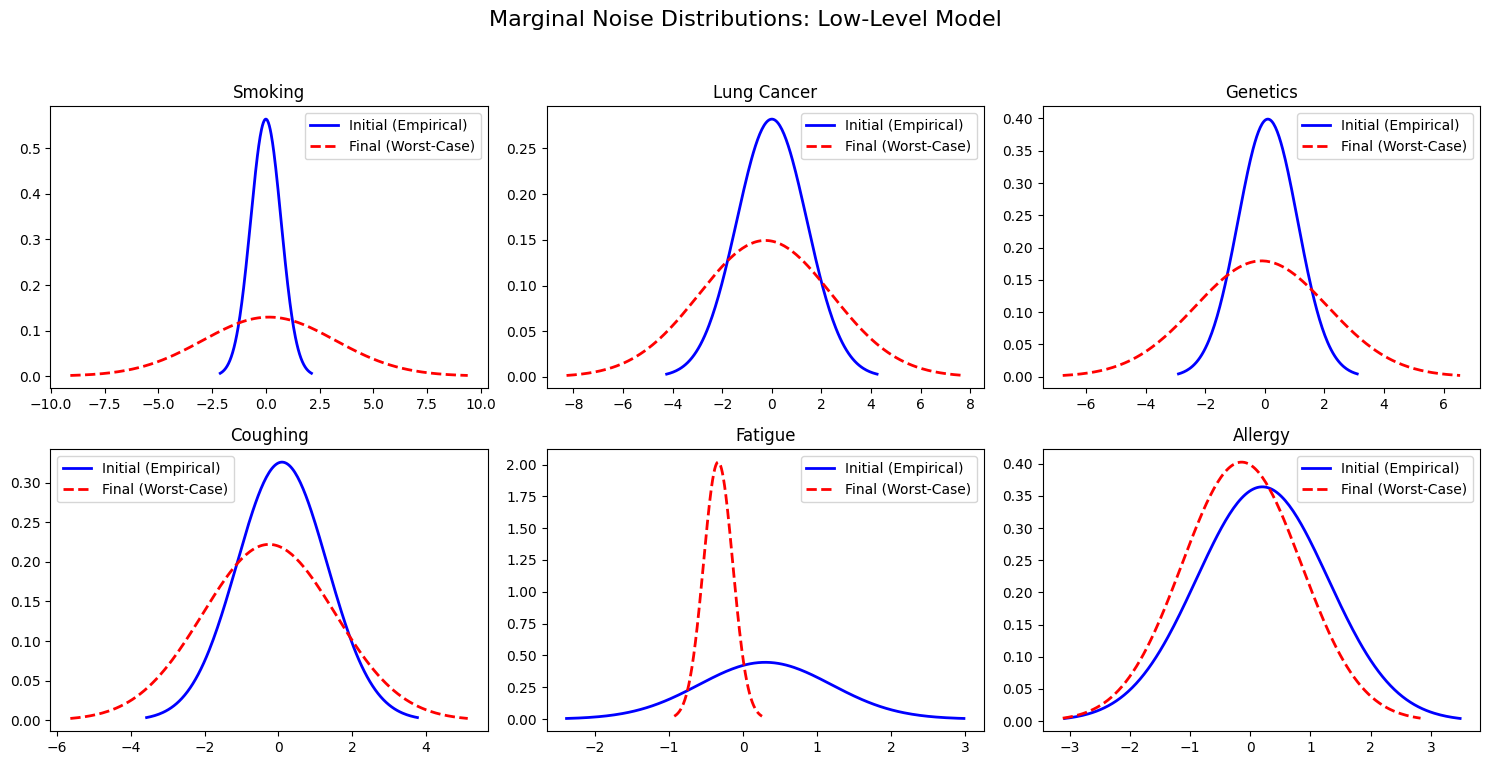


--- Distribution Summary: High-Level Model ---

Mean (μ):
  - Initial: [ 0.836 -0.     1.467]
  - Final  : [1.632 0.796 2.263]

Variances (diag(Σ)):
  - Initial: [26.106  3.26  81.526]
  - Final  : [13.274 13.274 13.274]

Final Correlation Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
-----------------------------------------


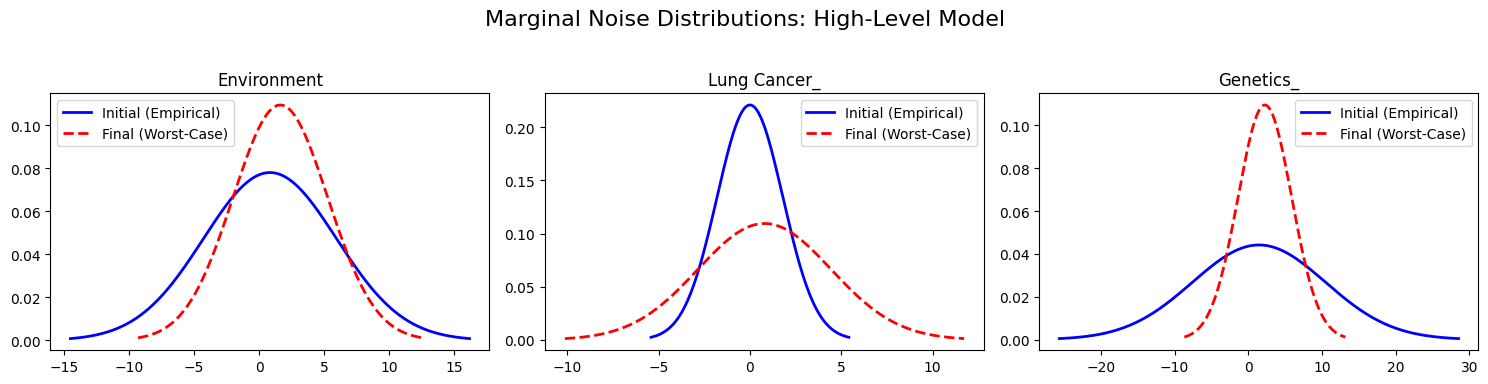

In [8]:
# Print the Numerical Summary for both LL and HL models and plot the marginal distributions
ll_var_names = list(all_data['LLmodel']['graph'].nodes())
hl_var_names = list(all_data['HLmodel']['graph'].nodes())

ut.print_distribution_summary(final_params['L'], initial_params_L, name="Low-Level Model")
ut.plot_marginal_distributions(final_params['L'], initial_params_L, ll_var_names, model_name="Low-Level Model")


ut.print_distribution_summary(final_params['H'], initial_params_H, name="High-Level Model")
ut.plot_marginal_distributions(final_params['H'], initial_params_H, hl_var_names, model_name="High-Level Model")

Total Trajectory Length (Low-Level): 37.3093
Distribution Spread (Low-Level): μ-Spread=0.1714, Σ-Spread=6.0316


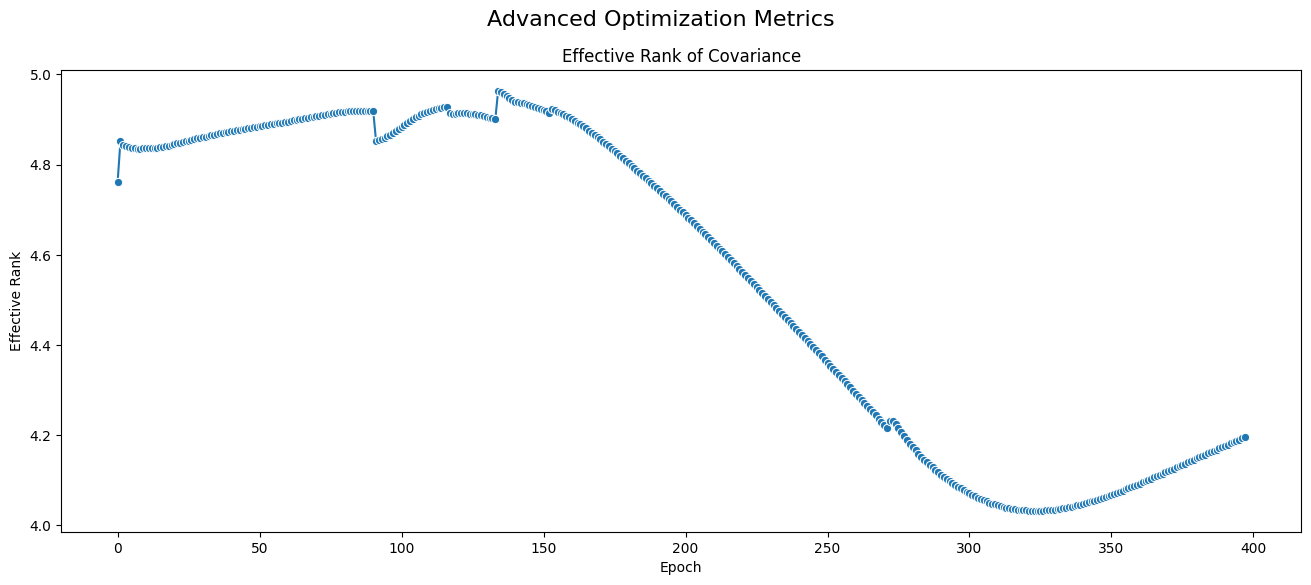

In [9]:
# Metric 1: Trajectory Length
traj_len = monitor.compute_trajectory_length(level='L')
print(f"Total Trajectory Length (Low-Level): {traj_len:.4f}")

# Metric 2: Diversity/Spread
spreads = monitor.compute_spread_metrics(level='L')
print(f"Distribution Spread (Low-Level): μ-Spread={spreads['spread_mu']:.4f}, Σ-Spread={spreads['spread_sigma']:.4f}")

# Metric 3: Effective Rank of Covariance
eff_ranks = monitor.compute_effective_rank_history(level='L')

fig, ax = plt.subplots(figsize=(16, 6))
fig.suptitle('Advanced Optimization Metrics', fontsize=16)

sns.lineplot(x=range(len(eff_ranks)), y=eff_ranks, marker='o', ax=ax)
ax.set_title('Effective Rank of Covariance')
ax.set_xlabel('Epoch')
ax.set_ylabel('Effective Rank')

plt.show()

In [10]:
# ll_var_names = list(all_data['LLmodel']['graph'].nodes())
# ut.create_optimization_animation(monitor, initial_params, ll_var_names, model_level='L', filename='ll_optimization.gif')

# hl_var_names = list(all_data['HLmodel']['graph'].nodes())
# ut.create_optimization_animation(monitor, initial_params, hl_var_names, model_level='H', filename='hl_optimization.gif')

### 2. GRADCA optimization

In [11]:
gradca_cv_results = {}

# 2. Outer Loop: Iterate through each cross-validation fold
for i, fold_info in enumerate(saved_folds):
    print(f"\n--- Starting Cross-Validation for Fold {i+1}/{len(saved_folds)} ---")
    
    # Create a new sub-dictionary for the current fold
    fold_key = f'fold_{i}'
    gradca_cv_results[fold_key] = {}
    
    # Determine the fold-specific radius bound
    train_n = len(fold_info['train'])

    # Assemble parameters for this specific run
    params_for_this_run = ut.assemble_fold_parameters(fold_info, all_data, hyperparams_gradca)
   
    # Prepare arguments for the optimization function
    opt_args = params_for_this_run.copy()
    opt_args.pop('k_folds', None)
    
    # Run the optimization
    trained_params, trained_T, monitor = optools.run_erica_optimization(**opt_args)

    # Store the results
    gradca_cv_results[fold_key] = {
        'gradca_run': {
            'T_matrix': trained_T,
            'test_indices': fold_info['test'] 
        }
    }
    
print("\n\n--- Optimization Complete ---")


--- Starting Cross-Validation for Fold 1/2 ---
Running optimization on device: cpu


Optimizing: 100%|██████████| 2000/2000 [05:45<00:00,  5.79it/s]



--- Starting Cross-Validation for Fold 2/2 ---
Running optimization on device: cpu


Optimizing: 100%|██████████| 2000/2000 [05:49<00:00,  5.72it/s]



--- Optimization Complete ---


In [13]:
import opt_tools as optools2

### 3. BARYCA optimization

In [14]:
baryca_cv_results = {}

for i, fold_info in enumerate(saved_folds):
    print(f"\n--- Starting Barycentric Optimization for Fold {i+1}/{len(saved_folds)} ---")
    
    opt_args = ut.assemble_barycentric_parameters(fold_info, all_data, hyperparams_baryca)
    opt_args.pop('k_folds', None)

    # Run the optimization
    trained_params, trained_T = optools2.barycentric_optimization(**opt_args)
    
    # Store the results 
    fold_key = f'fold_{i}'

    # Store the results
    baryca_cv_results[fold_key] = {
        'baryca_run': {
            'T_matrix': trained_T,
            'test_indices': fold_info['test'] 
        }
    }
print("\n\n--- Optimization Complete ---")


--- Starting Barycentric Optimization for Fold 1/2 ---

--- Starting Barycentric Optimization for Fold 2/2 ---


--- Optimization Complete ---


## Save the results

In [15]:
joblib.dump(diroca_cv_results, f"data/{experiment}/diroca_cv_results.pkl")
joblib.dump(gradca_cv_results, f"data/{experiment}/gradca_cv_results.pkl")
joblib.dump(baryca_cv_results, f"data/{experiment}/baryca_cv_results.pkl")

print("All results have been saved successfully!")

All results have been saved successfully!


In [16]:
print('Done!')

Done!
